# Highway Network

In [1]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.layers import Dense, Activation, Multiply, Add, Lambda
from keras.initializers import Constant


class Highway(Layer):

    activation = None
    transform_gate_bias = None

    def __init__(self, activation='relu', transform_gate_bias=-1, **kwargs):
        self.activation = activation
        self.transform_gate_bias = transform_gate_bias
        super(Highway, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        dim = input_shape[-1]
        transform_gate_bias_initializer = Constant(self.transform_gate_bias)
        input_shape_dense_1 = input_shape[-1]
        self.dense_1 = Dense(units=dim, bias_initializer=transform_gate_bias_initializer)
        self.dense_1.build(input_shape)
        self.dense_2 = Dense(units=dim)
        self.dense_2.build(input_shape)
        self.trainable_weights = self.dense_1.trainable_weights + self.dense_2.trainable_weights

        super(Highway, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        dim = K.int_shape(x)[-1]
        transform_gate = self.dense_1(x)
        transform_gate = Activation("sigmoid")(transform_gate)
        carry_gate = Lambda(lambda x: 1.0 - x, output_shape=(dim,))(transform_gate)
        transformed_data = self.dense_2(x)
        transformed_data = Activation(self.activation)(transformed_data)
        transformed_gated = Multiply()([transform_gate, transformed_data])
        identity_gated = Multiply()([carry_gate, x])
        value = Add()([transformed_gated, identity_gated])
        return value

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config['activation'] = self.activation
        config['transform_gate_bias'] = self.transform_gate_bias
        return config

Using TensorFlow backend.


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, concatenate, Permute, Reshape, LSTM
from keras import Input, Model
from keras.backend import transpose

In [3]:
# Modify 'num_of_train_domains' and 'max_domain_length'
num_of_train_domains = 1200000
max_domain_length = 47
char_embed_size = 20

model = Sequential()
model.add(Embedding(num_of_train_domains, char_embed_size, input_length=max_domain_length))

conv_input = Input(shape=(47, 20))
pool_size = ()
conv_layers = list()

kernels=[2] * 20 + [3] * 10
for kernel_size in kernels:
    conv = Conv1D(32, kernel_size, strides=1, padding='same')(conv_input)
    permuted_conv = Permute((2, 1))(conv)
    pool = MaxPooling1D([permuted_conv.get_shape()[1]], strides=1, padding='valid')(permuted_conv)
    permuted_pool = Permute((2, 1))(pool)
    
    conv_layers.append(permuted_pool)

# conv_out = Concatenate()(conv_layers)
conv_out = concatenate(conv_layers, axis=2)
conv_model = Model(input=conv_input, output=conv_out)

model.add(conv_model)

W0816 09:23:48.607167  2600 deprecation_wrapper.py:119] From C:\Users\JeongDo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 09:23:48.619134  2600 deprecation_wrapper.py:119] From C:\Users\JeongDo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 09:23:48.620132  2600 deprecation_wrapper.py:119] From C:\Users\JeongDo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 09:23:48.639102  2600 deprecation_wrapper.py:119] From C:\Users\JeongDo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

C:\Users\JeongDo\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: 

In [4]:
model.add(Reshape((max_domain_length, -1)))

In [22]:
# from keras.legacy.layers import Highway

In [7]:
model.add(Highway(input_shape=(30, ) ))

In [10]:
model.add(LSTM())

TypeError: __init__() missing 1 required positional argument: 'units'

[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]


[[ 1  2  3  7  8  9]
 [ 4  5  6 10 11 12]]


(4, 3)


# 모델 시각화

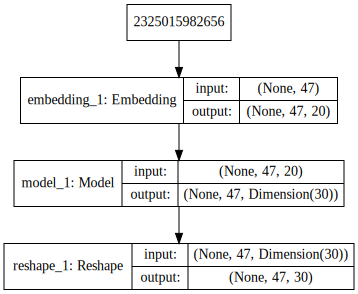

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

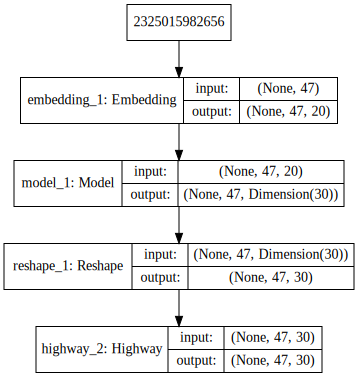

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))